$
\def\D{\Omega}
\def\ipar{m}
\def\R{\mathbb{R}}
\def\del{\partial}
\def\vec{\bf}
\def\priorm{\mu_0}
\def\C{\mathcal{C}}
\def\Acal{\mathcal{A}}
\def\postm{\mu_{\rm{post}}}
\def\iparpost{\ipar_\text{post}}
\def\obs{ {\vec d}} 
\def\yobs{\obs^{\text{obs}}}
\def\obsop{\mathcal{B}}
\def\dd{\vec{\bar{d}}}
\def\iFF{\mathcal{F}}
\def\iFFadj{\mathcal{F}^*}
\def\ncov{\Gamma_{\mathrm{noise}}}
$
# Bayesian initial condition inversion in an advection-diffusion problem 

In this example we tackle the problem of quantifying the uncertainty in the solution of an inverse problem governed by a parabolic PDE via the Bayesian inference framework. The underlying PDE is a time-dependent advection-diffusion equation in which we seek to infer an unknown initial condition from spatio-temporal point measurements.

### The Bayesian inverse problem:

Following the Bayesian framework, we utilize 
a Gaussian prior measure $\priorm = \mathcal{N}(\ipar_0,\C_0)$,
with $\C_0=\Acal^{-2}$ where $\Acal$ is an elliptic differential operator as 
described in the PoissonBayesian example, and use an additive
Gaussian noise model. Therefore, the solution of the Bayesian inverse
problem is the posterior measure, $\postm = \mathcal{N}(\iparpost,\C_\text{post})$ with
$\iparpost$ and $\C_\text{post}$.

- The posterior mean $\iparpost$ is characterized as the minimizer of

$$
\begin{aligned}
& \mathcal{J}(\ipar) :=
  \frac{1}{2} \left\| \obsop u(\ipar) -\obs  \right\|^2_{\ncov^{-1}}
  + \frac 12 \left\| \Acal(\ipar - \ipar_0 \right)\|^2_{L^2(\D)},
\end{aligned}
$$

which can also be interpreted as the regularized functional to be
minimized in deterministic inversion. The observation operator $\mathcal{B}$ extracts the values of the forward solution $u$ on a set of
locations $\{{\vec{x}}_1, \ldots, {\vec{x}}_n\} \subset \D$ at
times $\{t_1, \ldots, t_N\} \subset [0, T]$.

- The posterior covariance $\C_{\text{post}}$ is the inverse of the Hessian of $\mathcal{J}(\ipar)$, i.e.,

$$
\C_{\text{post}} = (\iFFadj \ncov^{-1} \iFF + \C_0^{-1})^{-1}.
$$


### The forward problem:

The parameter-to-observable map $\iFF \,\ipar := \obsop\, u(\ipar)$ maps an initial condition $\ipar \in L^2(\D)$ to pointwise spatiotemporal observations of the concentration field $u({\vec x},t)$ through solution of the advection-diffusion equation given by

$$
\begin{split}
u_t - \kappa\Delta u + {\vec v} \cdot \nabla u &= 0     & \quad \text{in } \D\times(0,T),\\
                                 u(\cdot, 0) &= \ipar & \quad \text{in } \D,\\
                \kappa \nabla u\cdot {\vec{n}} &= 0     & \quad \text{on } \partial\D \times (0,T).
\end{split}
$$

Here, $\D \subset \R^d$ ($d \in \{2, 3\}$) is a bounded domain, $\kappa > 0$ is the diffusion coefficient and $T > 0$ is the final
time. The velocity field
$\vec{v}$ is computed by solving the following steady-state
Navier-Stokes equation with the side walls driving the flow:

$$
\begin{aligned}
- \frac{1}{\operatorname{Re}} \Delta {\vec v} + \nabla q + {\vec v} \cdot \nabla {\vec v} &= 0 &\quad&\text{ in }\D,\\
\nabla \cdot {\vec v} &= 0 &&\text{ in }\D,\\
{\vec v} &= {\vec g} &&\text{ on } \partial\D.
\end{aligned}
$$

Here, $q$ is pressure, $\text{Re}$ is the Reynolds number. The Dirichlet boundary data
${\vec g} \in \R^d$ is given by 
${\vec g} = {\vec e}_2$ on the left wall of the domain, 
${\vec g}=-{\vec e}_2$ on the right wall,  and ${\vec g} = {\vec 0}$ everywhere else.

### The adjoint problem:

The adjoint problem is a final value problem, since $p$ is specified at $t = T$ rather than at $t = 0$. Thus, it is solved backwards in time, which amounts to the solution of the advection-diffusion equation

$$
\begin{aligned}
-p_t - \nabla \cdot (p {\vec v}) - \kappa \Delta p  &= -\obsop^* (\obsop u - \obs) & \quad &\text{ in } \D\times (0,T),\\
                                      p(\cdot, T) &= 0             &       &\text{ in } \D,\\ 
({ \vec{v} }p+\kappa\nabla p)\cdot {\vec{n}}            &= 0             &       &\text{ on } \partial\D\times (0,T).
\end{aligned}
$$

Then, the adjoint of the parameter to observable map $\iFF^*$ is defined by setting $\iFF^*\obs = p({\vec x}, 0).$

## 1. Load modules

In [1]:
from __future__ import absolute_import, division, print_function

import dolfin as dl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "..") + "/applications/ad_diff/" )
from model_ad_diff import TimeDependentAD

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

## 2. Construct the velocity field

In [2]:
def v_boundary(x,on_boundary):
    return on_boundary

def q_boundary(x,on_boundary):
    return x[0] < dl.DOLFIN_EPS and x[1] < dl.DOLFIN_EPS
        
def computeVelocityField(mesh):
    Xh = dl.VectorFunctionSpace(mesh,'Lagrange', 2)
    Wh = dl.FunctionSpace(mesh, 'Lagrange', 1)
    if dlversion() <= (1,6,0):
        XW = dl.MixedFunctionSpace([Xh, Wh])
    else:
        mixed_element = dl.MixedElement([Xh.ufl_element(), Wh.ufl_element()])
        XW = dl.FunctionSpace(mesh, mixed_element)

    Re = 1e2
    
    g = dl.Expression(('0.0','(x[0] < 1e-14) - (x[0] > 1 - 1e-14)'), degree=1)
    bc1 = dl.DirichletBC(XW.sub(0), g, v_boundary)
    bc2 = dl.DirichletBC(XW.sub(1), dl.Constant(0), q_boundary, 'pointwise')
    bcs = [bc1, bc2]
    
    vq = dl.Function(XW)
    (v,q) = dl.split(vq)
    (v_test, q_test) = dl.TestFunctions (XW)
    
    def strain(v):
        return dl.sym(dl.nabla_grad(v))
    
    F = ( (2./Re)*dl.inner(strain(v),strain(v_test))+ dl.inner (dl.nabla_grad(v)*v, v_test)
           - (q * dl.div(v_test)) + ( dl.div(v) * q_test) ) * dl.dx
           
    dl.solve(F == 0, vq, bcs, solver_parameters={"newton_solver":
                                         {"relative_tolerance":1e-4, "maximum_iterations":100}})
    
    plt.figure(figsize=(15,5))
    vh = dl.project(v,Xh)
    qh = dl.project(q,Wh)
    nb.plot(nb.coarsen_v(vh), subplot_loc=121,mytitle="Velocity")
    nb.plot(qh, subplot_loc=122,mytitle="Pressure")
    plt.show()
        
    return v

## 3. Set up the mesh and finite element spaces

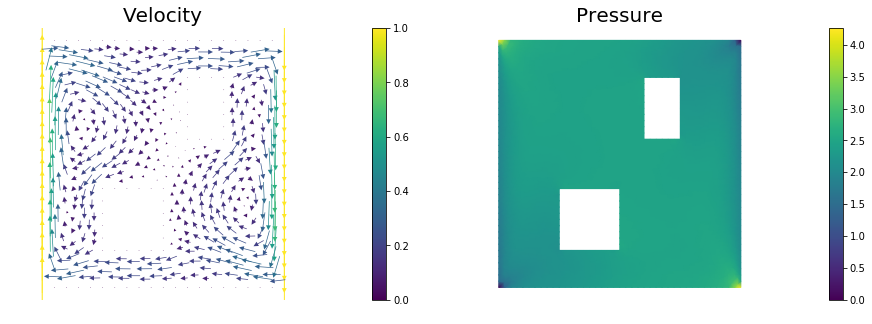

Number of dofs: 2023


In [3]:
mesh = dl.refine( dl.Mesh("ad_20.xml") )
wind_velocity = computeVelocityField(mesh)
Vh = dl.FunctionSpace(mesh, "Lagrange", 1)
print( "Number of dofs: {0}".format( Vh.dim() ) )

## 4. Set up model (prior, true/proposed initial condition)

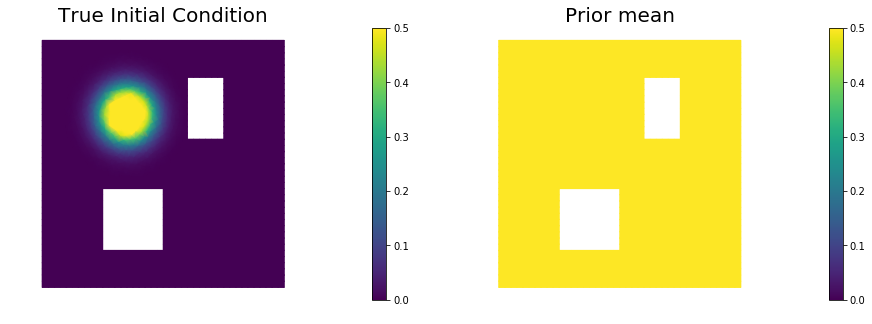

In [4]:
gamma = 1
delta = 8
prior = BiLaplacianPrior(Vh, gamma, delta)

prior.mean = dl.interpolate(dl.Constant(0.5), Vh).vector()
true_initial_condition = dl.interpolate(dl.Expression('min(0.5,exp(-100*(pow(x[0]-0.35,2) +  pow(x[1]-0.7,2))))', degree=5), Vh).vector()
problem = TimeDependentAD(mesh, [Vh,Vh,Vh], 0., 4., 1., .2, wind_velocity, True, prior)

objs = [dl.Function(Vh,true_initial_condition),
        dl.Function(Vh,prior.mean)]
mytitles = ["True Initial Condition", "Prior mean"]
nb.multi1_plot(objs, mytitles)
plt.show()

## 5. Generate the synthetic observations

noise_std_dev is: 0.0004970196187455547
STATE IS: 0
<class 'model_ad_diff.TimeDependentAD'>


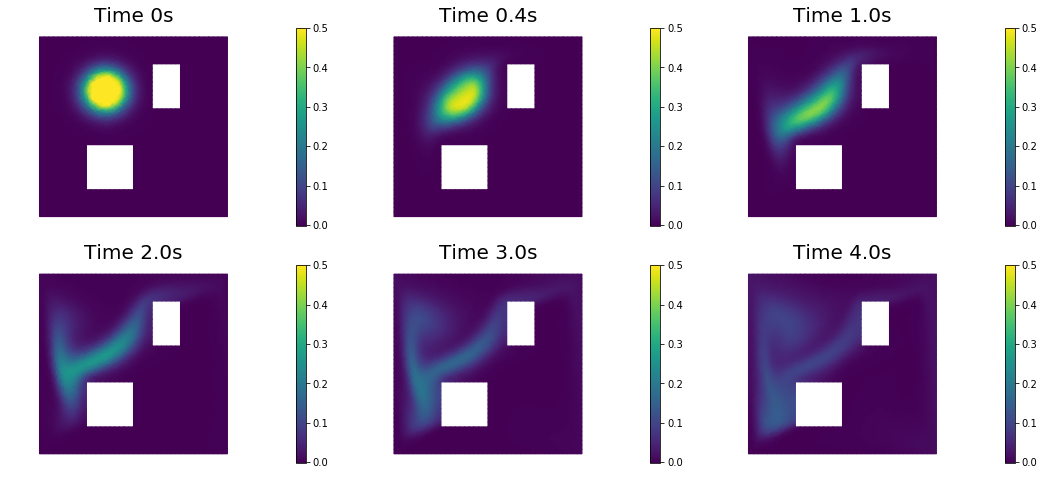

In [8]:
rel_noise = 0.001
utrue = problem.generate_vector(STATE)
x = [utrue, true_initial_condition, None]
problem.solveFwd(x[STATE], x, 1e-9)
MAX = utrue.norm("linf", "linf")
noise_std_dev = rel_noise * MAX
# problem.ud.zero()
# problem.ud.axpy(1., utrue)
print("noise_std_dev is: " + str(noise_std_dev))
print("STATE IS: " + str(STATE))
print(type(problem))
parRandom.normal_perturb(noise_std_dev, problem.ud)
problem.noise_variance = noise_std_dev*noise_std_dev

nb.show_solution(Vh, true_initial_condition, utrue, "Solution")

## 6. Test the gradient and the Hessian of the cost (negative log posterior)

(yy, H xx) - (xx, H yy) =  7.230028659845437e-14


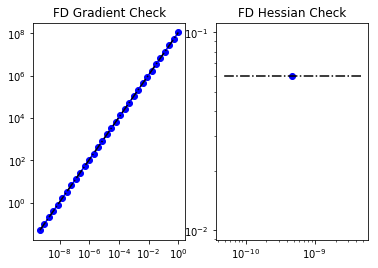

In [6]:
m0 = true_initial_condition.copy()
_ = modelVerify(problem, m0, 1e-12, is_quadratic=True)

## 7. Evaluate the gradient

In [7]:
[u,m,p] = problem.generate_vector()
problem.solveFwd(u, [u,m,p], 1e-12)
problem.solveAdj(p, [u,m,p], 1e-12)
mg = problem.generate_vector(PARAMETER)
grad_norm = problem.evalGradientParameter([u,m,p], mg)
        
print( "(g,g) = ", grad_norm)

(g,g) =  1662959298505.7039


## 8. The Gaussian posterior

Single Pass Algorithm. Requested eigenvectors: 80; Oversampling 20.


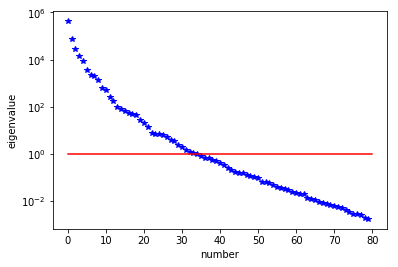

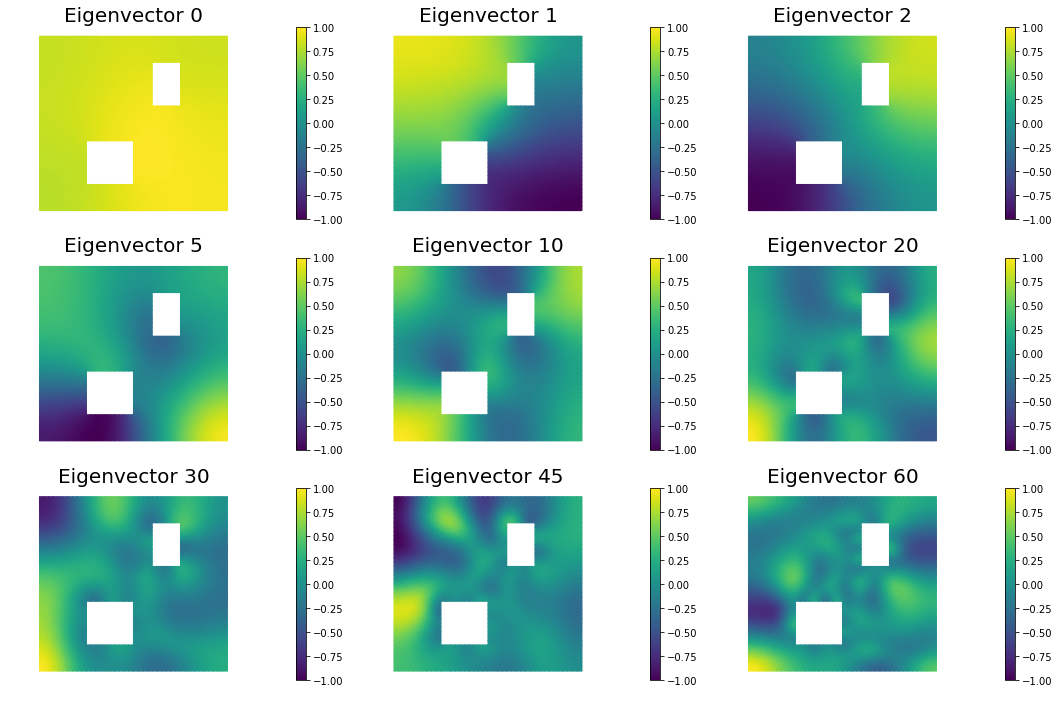

In [11]:
H = ReducedHessian(problem, 1e-12, misfit_only=True) 

k = 80
p = 20
print( "Single Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k,p) )
Omega = MultiVector(true_initial_condition, 80+p)
parRandom.normal(1., Omega)
lmbda, V = singlePassG(H, prior.R, prior.Rsolver, Omega, k)


posterior = GaussianLRPosterior( prior, lmbda, V )

plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')

nb.plot_eigenvectors(Vh, V, mytitle="Eigenvector", which=[0,1,2,5,10,20,30,45,60])

## 9. Compute the MAP point

 Iterartion :  0  (B r, r) =  30084.235543720704
 Iteration :  1  (B r, r) =  0.1401740221905336
 Iteration :  2  (B r, r) =  3.467479314573311e-05
 Iteration :  3  (B r, r) =  3.909772756568604e-10
Relative/Absolute residual less than tol
Converged in  3  iterations with final norm  1.9773145315221358e-05
Total cost 84.2423; Reg Cost 68.9031; Misfit 15.3392


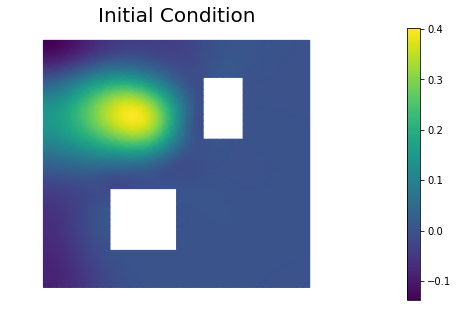

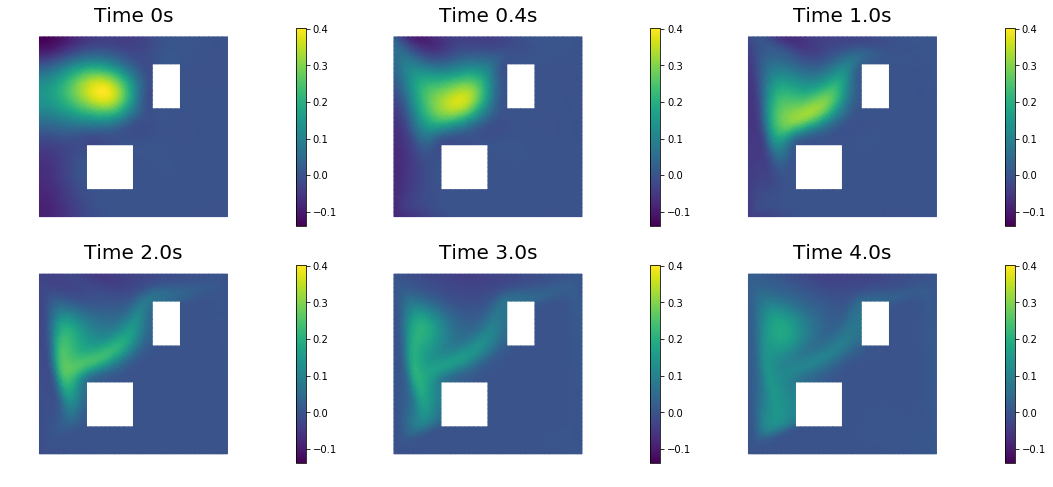

In [9]:
H.misfit_only = False
        
solver = CGSolverSteihaug()
solver.set_operator(H)
solver.set_preconditioner( posterior.Hlr )
solver.parameters["print_level"] = 1
solver.parameters["rel_tolerance"] = 1e-6
solver.solve(m, -mg)
problem.solveFwd(u, [u,m,p], 1e-12)
 
total_cost, reg_cost, misfit_cost = problem.cost([u,m,p])
print( "Total cost {0:5g}; Reg Cost {1:5g}; Misfit {2:5g}".format(total_cost, reg_cost, misfit_cost) )
    
posterior.mean = m

plt.figure(figsize=(7.5,5))
nb.plot(dl.Function(Vh, m), mytitle="Initial Condition")
plt.show()

nb.show_solution(Vh, m, u, "Solution")

## 10. Prior and posterior pointwise variance fields

Posterior trace 0.000603033; Prior trace 0.0285673; Correction trace 0.0279643


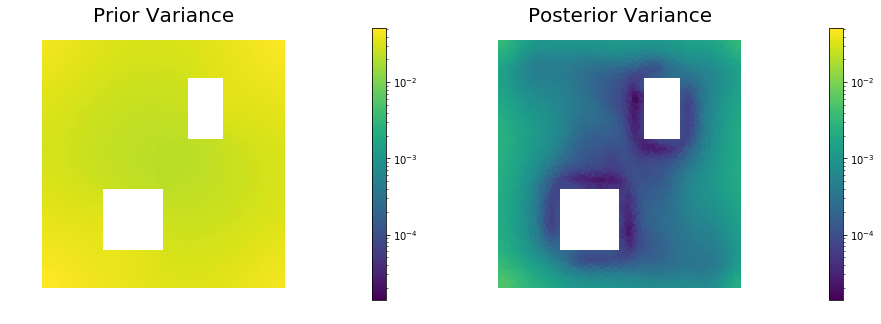

In [10]:
compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = posterior.trace(method="Randomized", r=200)
    print( "Posterior trace {0:5g}; Prior trace {1:5g}; Correction trace {2:5g}".format(post_tr, prior_tr, corr_tr) )
post_pw_variance, pr_pw_variance, corr_pw_variance = posterior.pointwise_variance(method="Randomized", r=300)

objs = [dl.Function(Vh, pr_pw_variance),
        dl.Function(Vh, post_pw_variance)]
mytitles = ["Prior Variance", "Posterior Variance"]
nb.multi1_plot(objs, mytitles, logscale=True)
plt.show()

## 11. Draw samples from the prior and posterior distributions

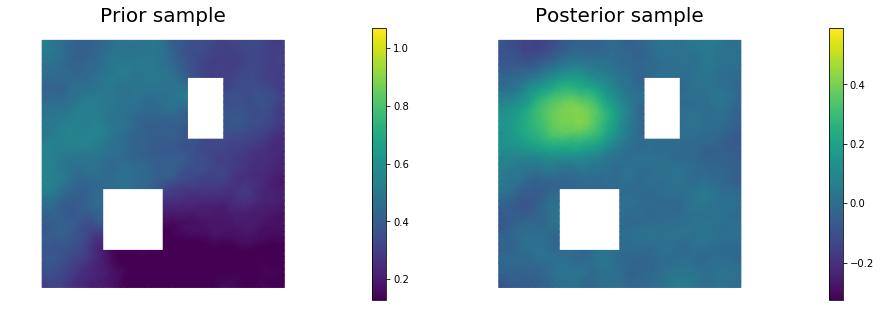

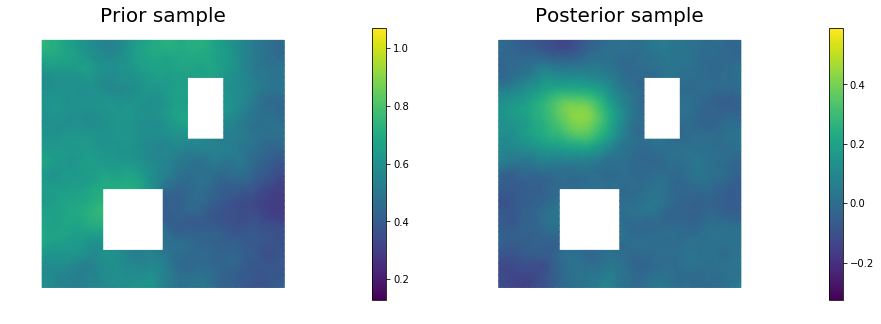

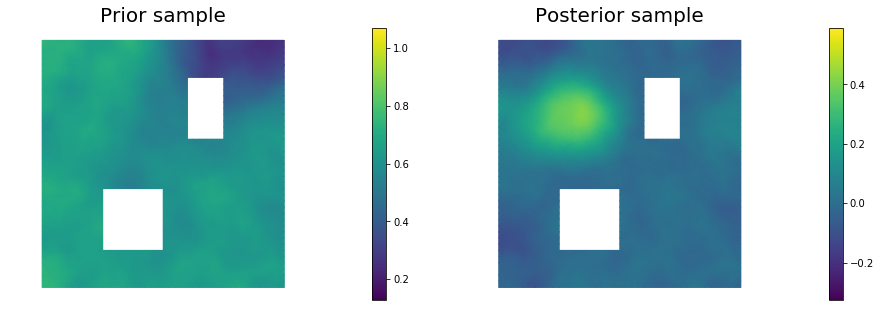

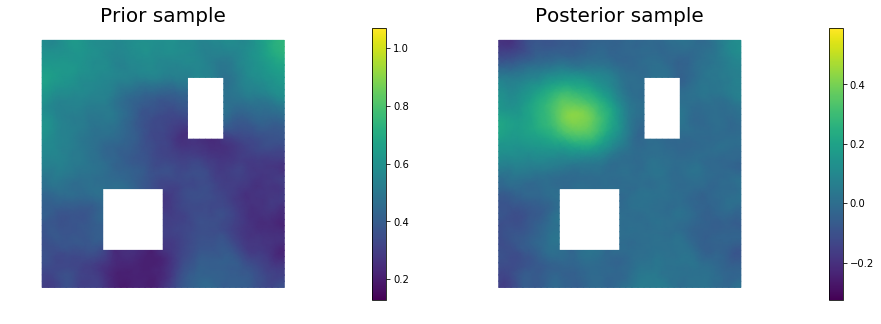

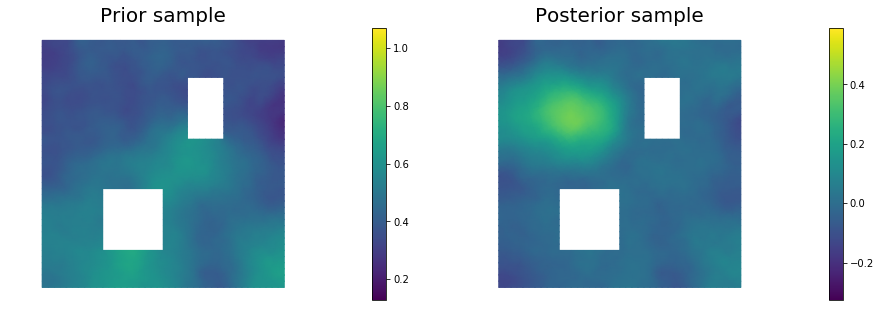

In [11]:
nsamples = 5
noise = dl.Vector()
posterior.init_vector(noise,"noise")
s_prior = dl.Function(Vh, name="sample_prior")
s_post = dl.Function(Vh, name="sample_post")

pr_max =  2.5*math.sqrt( pr_pw_variance.max() ) + prior.mean.max()
pr_min = -2.5*math.sqrt( pr_pw_variance.min() ) + prior.mean.min()
ps_max =  2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.max()
ps_min = -2.5*math.sqrt( post_pw_variance.max() ) + posterior.mean.min()

for i in range(nsamples):
    parRandom.normal(1., noise)
    posterior.sample(noise, s_prior.vector(), s_post.vector())
    plt.figure(figsize=(15,5))
    nb.plot(s_prior, subplot_loc=121,mytitle="Prior sample", vmin=pr_min, vmax=pr_max)
    nb.plot(s_post, subplot_loc=122,mytitle="Posterior sample", vmin=ps_min, vmax=ps_max)
    plt.show()

Copyright (c) 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.